# Let's preprocess some data

<div class="alert alert-block alert-info">

**TODO:**
* update texts according to new task and data
* clean code boxes and add comments
* commented boxes for getting data from Paituli/other places (for learning, but let's use data from allas)
* provide data on Allas (also in between products)
* commented boxes for reading in between results from Allas (if someone got lost)
* have it without outputs on Github

    
</div>

In [ ]:
# get orthophotos from Paituli





In [ ]:
# merge them
#smaller than OSM Helsinki, so no bbox
from rasterio.merge import merge
merged = merge(['../data/orthophotos/L4133A.jp2', '../data/orthophotos/L4133B.jp2', '../data/orthophotos/L4133C.jp2', '../data/orthophotos/L4133D.jp2'])

In [ ]:
import rasterio

with rasterio.open('../data/orthophotos/L4133A.jp2', 'r') as src:
    crs = src.crs

# write to file
with rasterio.open('../data/helsinki.tif', 'w', driver='GTiff',
    height= merged[0].shape[1],
    width= merged[0].shape[2],
    count=merged[0].shape[0],
    dtype=merged[0].dtype,
    crs=crs,
    transform=merged[1]) as dst:
        dst.write(merged[0])

In [1]:
import rasterio
with rasterio.open('../data/helsinki.tif', 'r') as src:
    merged = src.read(1)
    
merged.shape

(24000, 24000)

In [26]:
def download_and_prepare_gpkg(tags,classnumber,name):
    
      
    
    features = ox.geometries_from_bbox(60.2244208, 60.1133908, 25.0503325, 24.840953 , tags)
    #features = ox.geometries_from_place(place_name, tags)
    features = features.to_crs({'init':'epsg:3067'})
    #we want only polygons
    features = features[features.geom_type == 'Polygon']
    
    # we need only buildnig footprint (and ID)
    features = features.drop(features.columns.difference(['geometry']), axis =1)
    features['class'] = classnumber
    #buildings.head()
    # Plot footprints 
    features.plot()


    features.to_file('../data/helsinki_'+name+'.gpkg', driver='GPKG')
    return features

/home/samwitt/miniconda3/envs/geoconda/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


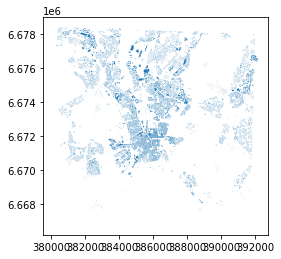

In [27]:
import osmnx as ox

# get buildings

# List key-value pairs for tags
tags = {'building': True}   

buildings = download_and_prepare_gpkg(tags,1,'buildings')

In [17]:
buildings.total_bounds


array([ 380126.73526472, 6666767.67924804,  392180.17865575,
       6678387.89768361])

/home/samwitt/miniconda3/envs/geoconda/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


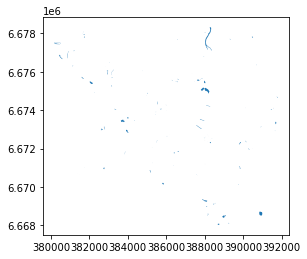

In [29]:
# get all small water

# List key-value pairs for tags
tags = {'natural': 'water','waterway':True, 'water':True}   

water = download_and_prepare_gpkg(tags,2,'water')


In [31]:
# create bbox of image extent

from shapely.geometry import box
import pandas as pd
import geopandas as gpd


df = pd.DataFrame({'a':['A']})
geometry = [box(380000, 6666000, 392000, 6678000)] 
geodf = gpd.GeoDataFrame(df, geometry=geometry)
geodf = geodf.set_crs('epsg:3067')

(4, 4)
(4, 2)


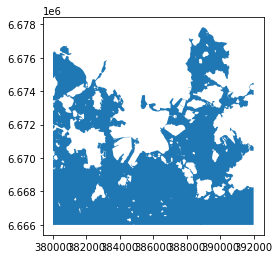

In [32]:
# get water/ocean polygon data from https://osmdata.openstreetmap.de/data/water-polygons.html
# read only small part of it and cut it with extent
# read from allas: v = gpd.read_file('/vsis3/name_of_your_Allas_bucket/name_of_your_input_vector_file.gpkg', bbox = (xx))?


waterpoly2 = gpd.read_file('/home/samwitt/Downloads/water-polygons-split-4326/water_polygons.shp' , bbox = (24.95,60.2 , 25.1,60.3 ))
#waterpoly2.head()
#waterpoly2.plot()
waterpoly2 = waterpoly2.to_crs({'init':'epsg:3067'})
#p =waterpoly2.overlay(geodf, how='overlay')
waterpoly = waterpoly2.overlay(geodf)
waterpoly.plot()
print(waterpoly.shape)
waterpoly['class'] = 2
waterpoly.drop(waterpoly.columns.difference(['geometry','class']), axis =1, inplace=True)
print(waterpoly.shape)

In [33]:
#merge ocean and water, class 2
water = gpd.read_file('../data/helsinki_water.gpkg')
print(water.shape)
print(waterpoly.shape)
waters = water.append(waterpoly)
print(waters.shape)
waterpoly = None
waters = waters.overlay(geodf)
waters.to_file('../data/helsinki_waterpoly.gpkg', driver='GPKG')


/home/samwitt/miniconda3/envs/geoconda/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(135, 4)
(4, 2)
(139, 4)


<AxesSubplot:>

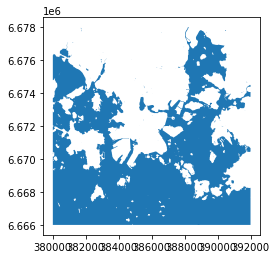

In [20]:
waters.plot()

/home/samwitt/miniconda3/envs/geoconda/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


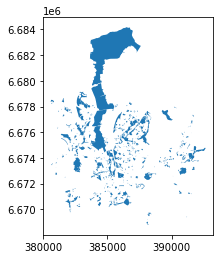

In [34]:
#get parks

# List key-value pairs for tags
tags = {'leisure': 'park'}   

parks = download_and_prepare_gpkg(tags,3,'parks')



/home/samwitt/miniconda3/envs/geoconda/lib/python3.8/site-packages/geopandas/geodataframe.py:639: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

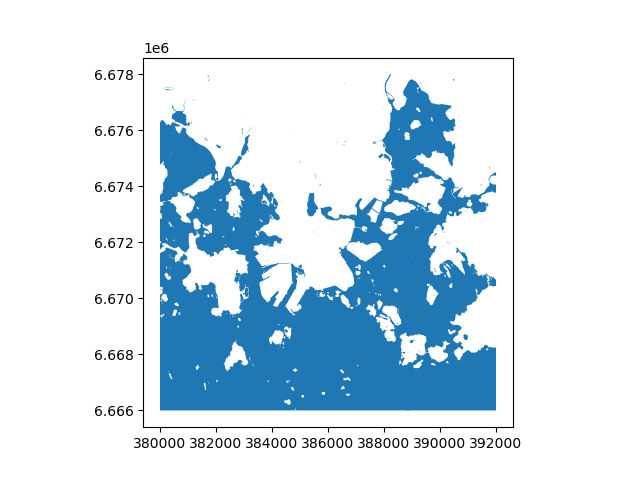

In [39]:
import geopandas as gpd
buildings = gpd.read_file('../data/helsinki_buildings.gpkg')
parks = gpd.read_file('../data/helsinki_parks.gpkg')
water = gpd.read_file('../data/helsinki_waterpoly.gpkg')
water.plot()

<AxesSubplot:>

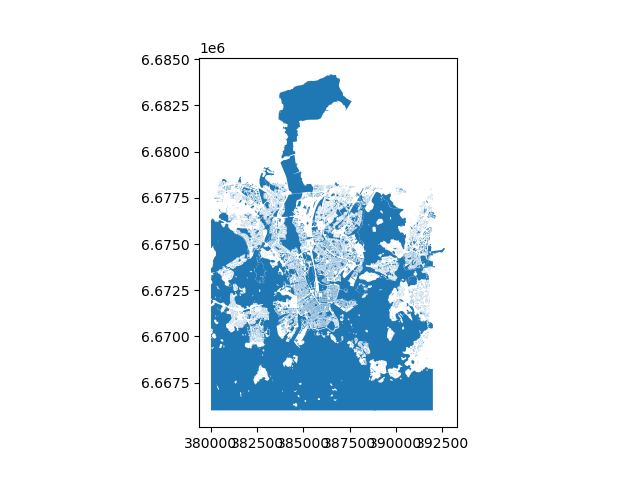

In [40]:
# create class vectorfile
classes = parks.append(water)
classes = classes.append(buildings)

parks = None
water = None
buildings=None

classes.plot()

In [41]:
# rasterize

import rasterio
from rasterio import features
import numpy
from rasterio.enums import MergeAlg
#copy and update the metadata from the input raster for the output
with rasterio.open('../data/helsinki.tif') as src:
    meta = src.meta.copy()
    meta.update(count=1)
    meta.update(compress='lzw')
    shape = src.read(1).shape
    transform = src.transform

#Now burn the features into the raster and write it out

outname = '../data/classes.tif'

print('hey')

hey


In [42]:
# this is where we create a generator of geom, value pairs to use in rasterizing
shapes = ((geom,value) for geom, value in zip(classes.geometry, classes['class']))

#burned = features.rasterize(shapes=shapes, fill=10, out_shape = shape, out=None, transform=out.transform, all_touched =True, default_value= 100, dtype="uint8")
print('ho')
rasterized = features.rasterize(shapes,
                                out_shape = shape,
                                transform = transform,
                                all_touched = True,
                                fill = 0,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = numpy.uint8)

#print(numpy.unique(rasterized))
print('here')

with rasterio.open(outname, 'w+', **meta) as out:
    out.write_band(1, rasterized)



ho
here


In [44]:
#%matplotlib widget

from matplotlib import pyplot
import rasterio
from rasterio.windows import from_bounds
from matplotlib.colors import ListedColormap
import numpy
with rasterio.open('../data/classes.tif','r' ) as src:
    print('ho')
    #img = src.read(window=from_bounds(380000, 6666000, 392000, 6678000, src.transform))
    img = src.read(1)
    print(img.shape)
    """
    img[img==0] = numpy.nan
    current_cmap = plt.cm.get_cmap('Set1')
    current_cmap.set_bad("white")
    """
    cmap = ListedColormap(['w','r', 'b', 'g'])
    pyplot.imshow(img, cmap = cmap)

ho
(24000, 24000)
